In [5]:
!pip install tslearn

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# -*- coding: utf-8 -*-

# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.metrics import dtw, cdist_dtw # tslearn: 시계열 DTW 거리 계산
from tslearn.neighbors import KNeighborsTimeSeriesClassifier # tslearn: DTW 기반 KNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
import random
import os
import xgboost as xgb
from collections import Counter
import tensorflow as tf

# 시드 고정
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# imblearn: 불균형 데이터 처리 관련 라이브러리
from imblearn.metrics import specificity_score # imblearn: 특이도(다수 클래스 재현율) 계산

# 두 시계열 데이터 사이의 합성 샘플 생성 함수 (선형 보간)
def generate_synthetic_sample(ts1, ts2, alpha=0.5):
    return ts1 + alpha * (ts2 - ts1)

# --- 데이터 로드 ---
print("데이터 로드 중...")
# 제공해주신 경로에서 CSV 파일을 읽어옵니다.
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')
print("데이터 로드 완료.")

# 데이터 numpy 배열로 변환
X_train = df_X_train.values
y_train = df_y_train.values.ravel()
X_test = df_X_test.values
y_test = df_y_test.values.ravel()

# 시계열 모델 (LSTM, CNN, tslearn KNN)은 (samples, timesteps, features) 형태를 사용
X_train_ts = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_ts = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 클래스 비율 확인 및 소수/다수 클래스 식별 (y_train 기준)
class_counts = Counter(y_train)
print(f"\n훈련 데이터 클래스 분포 (이상치 삭제 전): {class_counts}")

sorted_classes = class_counts.most_common()
majority_class = sorted_classes[0][0]
minority_class = sorted_classes[-1][0]

print(f"소수 클래스: {minority_class}, 다수 클래스: {majority_class}")

# --- 이상치 삭제 ---
# k 값 설정 (이웃 탐색 개수) - SMOTE에서 사용할 k와 동일하게 설정
k_neighbors_outlier = min(len(X_train_ts) - 1, 5)

# 이상치 삭제 결과 변수 초기화 (기본값은 원본 데이터)
X_train_ts_cleaned = X_train_ts
y_train_cleaned = y_train

# 이상치 탐지를 위한 이웃 개수가 1 이상인 경우에만 이상치 삭제 수행
if k_neighbors_outlier >= 1:
    # 전체 훈련 데이터 샘플들 간의 DTW 거리 계산
    dtw_dist_all_train = cdist_dtw(X_train_ts, X_train_ts, n_jobs=-1)

    outlier_indices = [] # 이상치로 식별된 샘플의 인덱스를 저장할 리스트

    # 모든 훈련 샘플에 대해 반복하며 이상치 여부 판별
    for i in range(len(X_train_ts)):
        current_sample_ts = X_train_ts[i]
        current_label = y_train[i]

        # 현재 샘플과 전체 훈련 샘플 간의 거리
        current_dist_row = dtw_dist_all_train[i, :]

        # 자기 자신(0번째)을 제외한 가장 가까운 k개 이웃의 인덱스
        sorted_indices = np.argsort(current_dist_row)
        k_neighbor_indices = sorted_indices[1 : k_neighbors_outlier + 1]

        # k개 이웃의 클래스 확인
        k_neighbor_classes = y_train[k_neighbor_indices]

        # 이상치 조건 확인: k 이웃이 모두 다른 클래스인 경우
        if current_label == minority_class:
            # 소수 클래스 샘플이 이상치인 경우: k 이웃이 모두 다수 클래스
            if np.all(k_neighbor_classes == majority_class):
                outlier_indices.append(i)
        elif current_label == majority_class:
            # 다수 클래스 샘플이 이상치인 경우: k 이웃이 모두 소수 클래스
            if np.all(k_neighbor_classes == minority_class):
                 outlier_indices.append(i)

    # 이상치 샘플을 제외한 새로운 훈련 데이터셋 생성
    all_indices = np.arange(len(X_train_ts))
    # 이상치 인덱스에 포함되지 않는 인덱스만 선택
    cleaned_indices = np.setdiff1d(all_indices, outlier_indices)

    X_train_ts_cleaned = X_train_ts[cleaned_indices]
    y_train_cleaned = y_train[cleaned_indices]

    print(f"식별된 이상치 샘플 수: {len(outlier_indices)}")
    print(f"이상치 삭제 후 훈련 데이터 shape (시계열): {X_train_ts_cleaned.shape}")
    print(f"이상치 삭제 후 훈련 레이블 shape: {y_train_cleaned.shape}")
    print(f"이상치 삭제 후 훈련 데이터 클래스 분포: {Counter(y_train_cleaned)}")


# SMOTE 및 모델 학습 단계에서 이상치 삭제된 데이터를 사용하도록 변수 업데이트
# 이상치 탐지 및 삭제 결과(X_train_ts_cleaned, y_train_cleaned)가 이 변수에 담깁니다.
X_train_ts = X_train_ts_cleaned
y_train = y_train_cleaned

# 이상치 삭제 후의 데이터로 소수/다수 클래스 및 인덱스 재분리
# 업데이트된 y_train을 기준으로 다시 클래스 분포를 확인하고 소수/다수 클래스를 식별합니다.
class_counts_cleaned = Counter(y_train)

# 클래스가 2개 이상인 경우 정상적으로 소수/다수 클래스 및 인덱스 설정
sorted_classes_cleaned = class_counts_cleaned.most_common()
majority_class = sorted_classes_cleaned[0][0]
minority_class = sorted_classes_cleaned[-1][0]
minority_indices = np.where(y_train == minority_class)[0]
majority_indices = np.where(y_train == majority_class)[0]
X_minority_ts = X_train_ts[minority_indices]
X_majority_ts = X_train_ts[majority_indices]
print(f"이상치 삭제 후 업데이트된 소수 클래스: {minority_class}, 다수 클래스: {majority_class}")


# --- DTW 기반 Borderline SMOTE (안전 샘플 증강) ---
# k 값 설정 (이웃 탐색 개수) - 이상치 탐지에서 사용한 k와 동일하게 유지
k_neighbors = k_neighbors_outlier

# 소수 클래스 샘플 vs 전체 훈련 데이터 DTW 거리 계산 (이상치 삭제된 데이터 기준)
# X_train_ts가 이상치 삭제된 데이터로 업데이트되었으므로 이 단계부터는 이상치 없는 데이터로 진행
# 단, 소수 클래스 샘플이 남아있는 경우에만 거리 계산
if len(X_minority_ts) > 0:
    dtw_dist_minority_all = cdist_dtw(X_minority_ts, X_train_ts, n_jobs=-1)
else:
    dtw_dist_minority_all = np.array([[]]) # 빈 배열로 설정하여 이후 루프 실행 방지


# 소수 클래스 샘플을 '안전 샘플'로 분리 (k 이웃 중 소수 < 다수)
safe_minority_original_indices = []

# X_minority_ts에 있는 각 소수 클래스 샘플에 대해 반복 (이상치 삭제된 소수 클래스 데이터)
# 소수 클래스 샘플이 남아있는 경우에만 루프 실행
if len(X_minority_ts) > 0:
    for i in range(len(X_minority_ts)):
        current_minority_dist_row = dtw_dist_minority_all[i, :]

        sorted_indices = np.argsort(current_minority_dist_row)
        # 자기 자신 제외 k 이웃 (이상치 삭제된 훈련 데이터에서의 인덱스)
        k_neighbor_indices = sorted_indices[1 : k_neighbors + 1]

        # k개 이웃이 있고 클래스 정보가 유효한 경우에만 분류
        if len(k_neighbor_indices) > 0 and y_train is not None and len(np.unique(y_train)) > 1:
            k_neighbor_classes = y_train[k_neighbor_indices] # 이상치 삭제된 訓練 레이블에서의 이웃 클래스

            num_minority_neighbors = np.sum(k_neighbor_classes == minority_class)
            num_majority_neighbors = np.sum(k_neighbor_classes == majority_class)

            if num_minority_neighbors < num_majority_neighbors:
                 safe_minority_original_indices.append(minority_indices[i])

X_safe_minority_ts = X_train_ts[safe_minority_original_indices] # 안전 샘플의 피처 데이터
print(f"안전 소수 클래스 샘플 수 (이상치 삭제 후 SMOTE 대상): {len(X_safe_minority_ts)}")


# 안전 샘플과 가장 가까운 다수 클래스 샘플 사이에 데이터 증강
synthetic_samples = []
synthetic_labels = []

# 증강 데이터 변수를 이상치 삭제된 훈련 데이터로 초기화
X_augmented_ts = X_train_ts
y_augmented = y_train

# 이상치 삭제 후 다수 클래스 샘플이 존재하고 안전 소수 클래스 샘플이 존재하며, SMOTE가 필요한 경우에만 합성 데이터 생성 수행
# minority_class와 majority_class가 None이 아닌 경우만 진행하도록 추가 조건
if len(X_majority_ts) > 0 and len(X_safe_minority_ts) > 0 and minority_class is not None and majority_class is not None:
    # 생성할 합성 데이터 총 개수 결정 (소수 클래스 수를 다수 클래스 수와 같게 만듦)
    target_minority_count = len(X_majority_ts)
    current_minority_count = len(X_minority_ts) # 이상치 삭제 후의 소수 클래스 수
    num_samples_to_generate = target_minority_count - current_minority_count

    if num_samples_to_generate > 0:
         # 안전 소수 클래스 샘플 vs 소수 클래스 샘플 DTW 거리 계산 (이상치 삭제된 데이터 기준)
         dtw_dist_safe_to_minority = cdist_dtw(X_safe_minority_ts, X_minority_ts, n_jobs=-1)

         samples_per_safe_sample_base = num_samples_to_generate // len(X_safe_minority_ts)
         remainder = num_samples_to_generate % len(X_safe_minority_ts)

         for i in range(len(X_safe_minority_ts)):
            safe_sample_ts = X_safe_minority_ts[i]
            # 현재 안전 샘플 (X_safe_minority_ts[i])에 가장 가까운 '다른' 소수 클래스 샘플 찾기
            # X_safe_minority_ts[i]와 X_minority_ts 내 모든 샘플 간의 거리
            distances_to_minority_samples = dtw_dist_safe_to_minority[i, :]

            # 거리를 오름차순으로 정렬하고 인덱스를 얻습니다.
            sorted_minority_neighbor_indices = np.argsort(distances_to_minority_samples)

            closest_minority_neighbor_idx_in_minority_list = sorted_minority_neighbor_indices[1]

            closest_minority_sample_ts = X_minority_ts[closest_minority_neighbor_idx_in_minority_list]

            # 현재 안전 샘플 당 생성할 샘플 개수 결정
            num_to_generate_this_sample = samples_per_safe_sample_base
            if remainder > 0:
                num_to_generate_this_sample += 1
                remainder -= 1

            # 합성 샘플 생성 (선형 보간)
            for _ in range(num_to_generate_this_sample):
                alpha = random.random()
                synthetic_sample = generate_synthetic_sample(safe_sample_ts, closest_minority_sample_ts, alpha=alpha)
                synthetic_samples.append(synthetic_sample)
                synthetic_labels.append(minority_class)

# 생성된 합성 데이터가 있으면 이상치 삭제된 원래 데이터와 합치기
if synthetic_samples:
    X_synthetic_ts = np.array(synthetic_samples)
    y_synthetic = np.array(synthetic_labels)
    print(f"생성된 합성 데이터 수: {len(X_synthetic_ts)}")
    # 이상치 삭제된 데이터와 생성된 합성 데이터를 합쳐 최종 증강된 훈련 데이터셋 구축
    X_augmented_ts = np.concatenate([X_train_ts, X_synthetic_ts], axis=0)
    y_augmented = np.concatenate([y_train, y_synthetic], axis=0)
    print(f"증강된 훈련 데이터 shape (시계열): {X_augmented_ts.shape}")
    print(f"증강된 훈련 레이블 shape: {y_augmented.shape}")


# 표준 모델 학습을 위한 데이터 (flattened) 준비
X_augmented = X_augmented_ts.reshape(X_augmented_ts.shape[0], -1)
X_test_flat = X_test_ts.reshape(X_test_ts.shape[0], -1)

# --- 모델 정의 및 학습 함수 ---

def predict_with_logistic_regression(X_train_data, y_train_data, X_test_data):
    print("Logistic Regression 모델 학습 중...")
    model = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
    model.fit(X_train_data, y_train_data)
    print("Logistic Regression 모델 학습 완료.")
    return model.predict(X_test_data)

def predict_with_cart(X_train_data, y_train_data, X_test_data):
    print("CART 모델 학습 중...")
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_data, y_train_data)
    print("CART 모델 학습 완료.")
    return model.predict(X_test_data)

def predict_with_knn(X_train_data_ts, y_train_data, X_test_data_ts):
    print("KNN (DTW) 모델 학습 중...")
    n_knn_neighbors = min(len(y_train_data), 5) if len(y_train_data) > 0 else 1
    if n_knn_neighbors < 1: n_knn_neighbors = 1
    model = KNeighborsTimeSeriesClassifier(n_neighbors=n_knn_neighbors, metric="dtw", n_jobs=-1)
    model.fit(X_train_data_ts, y_train_data)
    print("KNN (DTW) 모델 학습 완료.")
    return model.predict(X_test_data_ts)


def predict_with_xgboost(X_train_data, y_train_data, X_test_data):
    print("XGBoost 모델 학습 중...")
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', random_state=42)
    model.fit(X_train_data, y_train_data)
    print("XGBoost 모델 학습 완료.")
    return model.predict(X_test_data)


def predict_with_lstm(X_train_data_ts, y_train_data, X_test_data_ts):
    print("LSTM 모델 학습 중...")
    unique_train_classes = np.unique(y_train_data)
    all_possible_classes = np.unique(np.concatenate([y_train_data, y_test]))
    num_classes = len(all_possible_classes)
    y_train_one_hot = to_categorical(y_train_data, num_classes=num_classes)

    input_shape = (X_train_data_ts.shape[1], X_train_data_ts.shape[2])

    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train_data_ts, y_train_one_hot, epochs=50, batch_size=32, verbose=0)
    print("LSTM 모델 학습 완료.")
    pred_probs = model.predict(X_test_data_ts)
    return np.argmax(pred_probs, axis=1)


def predict_with_cnn(X_train_data_ts, y_train_data, X_test_data_ts):
    print("CNN 모델 학습 중...")
    unique_train_classes = np.unique(y_train_data)
    all_possible_classes = np.unique(np.concatenate([y_train_data, y_test]))
    num_classes = len(all_possible_classes)
    y_train_one_hot = to_categorical(y_train_data, num_classes=num_classes)

    input_shape = (X_train_data_ts.shape[1], X_train_data_ts.shape[2])

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train_data_ts, y_train_one_hot, epochs=50, batch_size=32, verbose=0)
    print("CNN 모델 학습 완료.")
    pred_probs = model.predict(X_test_data_ts)
    return np.argmax(pred_probs, axis=1)


# --- 예측 결과 저장 및 성능 평가 ---

print("\n\n--- 모델별 성능 평가 결과 ---")

predictions = {}

X_train_for_flat = X_augmented
y_train_for_flat = y_augmented
X_test_for_flat = X_test_flat
X_train_for_ts = X_augmented_ts
y_train_for_ts = y_augmented
X_test_for_ts = X_test_ts

데이터 로드 중...
데이터 로드 완료.

훈련 데이터 클래스 분포 (이상치 삭제 전): Counter({np.int64(1): 1172, np.int64(0): 62})
소수 클래스: 0, 다수 클래스: 1
식별된 이상치 샘플 수: 38
이상치 삭제 후 훈련 데이터 shape (시계열): (1196, 80, 1)
이상치 삭제 후 훈련 레이블 shape: (1196,)
이상치 삭제 후 훈련 데이터 클래스 분포: Counter({np.int64(1): 1172, np.int64(0): 24})
이상치 삭제 후 업데이트된 소수 클래스: 0, 다수 클래스: 1
안전 소수 클래스 샘플 수 (이상치 삭제 후 SMOTE 대상): 24
생성된 합성 데이터 수: 1148
증강된 훈련 데이터 shape (시계열): (2344, 80, 1)
증강된 훈련 레이블 shape: (2344,)


--- 모델별 성능 평가 결과 ---


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [10]:
# 10. Stratified K-Fold 교차 검증
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K-Fold 사용

In [11]:
# 11. 교차 검증 및 모델 학습
best_threshold = None
best_specificity = 0
best_model = None

for fold, (train_index, val_index) in enumerate(skf.split(X_augmented_ts, y_augmented)): #X_train_resampled, y_train_resampled로 학습
    print(f"Fold {fold+1}")

    # 데이터 분할
    X_train_fold, X_val_fold = X_augmented_ts[train_index], X_augmented_ts[val_index] #X_train_resampled, y_train_resampled로 학습
    y_train_fold, y_val_fold = y_augmented[train_index], y_augmented[val_index] #X_train_resampled, y_train_resampled로 학습

    # Reshape the data to 2D for RandomForestClassifier
    X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], -1)
    X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], -1)


    rf_model = RandomForestClassifier(random_state=42)
    # 모델 학습
    rf_model.fit(X_train_fold, y_train_fold)

    # 검증 데이터 예측 (확률값 예측)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]

    # 최적 임계값 찾기 (Specificity 최대화)
    thresholds = np.linspace(0, 1, 100)  # 임계값 후보 생성
    for threshold in thresholds:
        y_pred_temp = (y_pred_proba >= threshold).astype(int)
        specificity = specificity_score(y_val_fold, y_pred_temp)
        if specificity > best_specificity:
            best_specificity = specificity
            best_threshold = threshold
            best_model = rf_model # 현재 fold의 모델 저장

print(f"Best Threshold: {best_threshold}")

# 12. 테스트 데이터 예측 (최적 모델 및 임계값 사용)
# Reshape X_test to 2D before prediction
X_test_2d = X_test.reshape(X_test.shape[0], -1)
y_pred_proba = best_model.predict_proba(X_test_2d)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Best Threshold: 0.5252525252525253


Logistic Regression 모델 학습 중...
Logistic Regression 모델 학습 완료.
CART 모델 학습 중...
CART 모델 학습 완료.
KNN (DTW) 모델 학습 중...
KNN (DTW) 모델 학습 완료.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBoost 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:30:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 모델 학습 완료.
LSTM 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM 모델 학습 완료.
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
CNN 모델 학습 중...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN 모델 학습 완료.
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

--- Logistic Regression 모델 성능 ---
모델 성능 평가:
  정확도: 0.6492
  F1-Score (소수 클래스 0): 0.4155
  재현율 (Recall, 소수 클래스 0): 0.3223
  특이도 (Specificity, 다수 클래스 1): 0.3223
  혼동 행렬 (Confusion Matrix):
[[107 225]
 [ 76 450]]


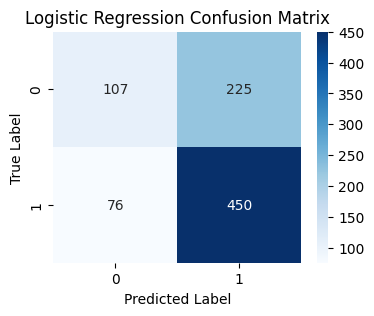


--- CART 모델 성능 ---
모델 성능 평가:
  정확도: 0.6445
  F1-Score (소수 클래스 0): 0.1995
  재현율 (Recall, 소수 클래스 0): 0.1145
  특이도 (Specificity, 다수 클래스 1): 0.1145
  혼동 행렬 (Confusion Matrix):
[[ 38 294]
 [ 11 515]]


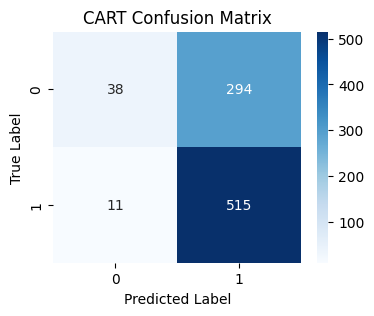


--- KNN (DTW) 모델 성능 ---
모델 성능 평가:
  정확도: 0.6830
  F1-Score (소수 클래스 0): 0.3585
  재현율 (Recall, 소수 클래스 0): 0.2289
  특이도 (Specificity, 다수 클래스 1): 0.2289
  혼동 행렬 (Confusion Matrix):
[[ 76 256]
 [ 16 510]]


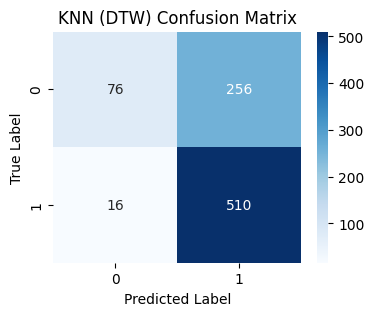


--- XGBoost 모델 성능 ---
모델 성능 평가:
  정확도: 0.6410
  F1-Score (소수 클래스 0): 0.1397
  재현율 (Recall, 소수 클래스 0): 0.0753
  특이도 (Specificity, 다수 클래스 1): 0.0753
  혼동 행렬 (Confusion Matrix):
[[ 25 307]
 [  1 525]]


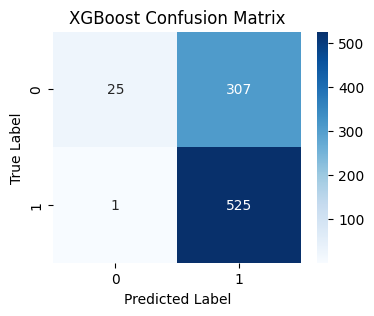


--- LSTM 모델 성능 ---
모델 성능 평가:
  정확도: 0.6399
  F1-Score (소수 클래스 0): 0.4412
  재현율 (Recall, 소수 클래스 0): 0.3675
  특이도 (Specificity, 다수 클래스 1): 0.3675
  혼동 행렬 (Confusion Matrix):
[[122 210]
 [ 99 427]]


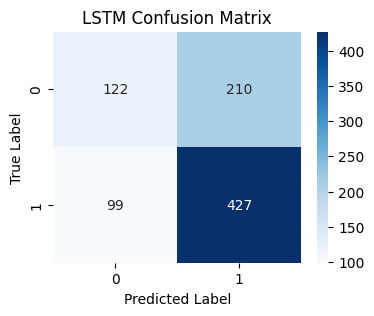


--- CNN 모델 성능 ---
모델 성능 평가:
  정확도: 0.6830
  F1-Score (소수 클래스 0): 0.3166
  재현율 (Recall, 소수 클래스 0): 0.1898
  특이도 (Specificity, 다수 클래스 1): 0.1898
  혼동 행렬 (Confusion Matrix):
[[ 63 269]
 [  3 523]]


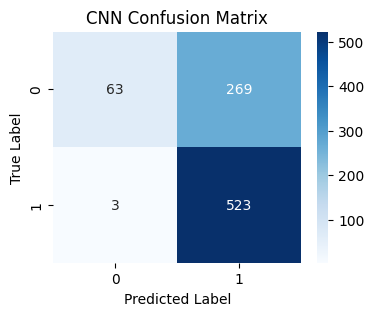

In [8]:
predictions["Logistic Regression"] = predict_with_logistic_regression(X_train_for_flat, y_train_for_flat, X_test_for_flat)
predictions["CART"] = predict_with_cart(X_train_for_flat, y_train_for_flat, X_test_for_flat)
predictions["KNN (DTW)"] = predict_with_knn(X_train_for_ts, y_train_for_ts, X_test_for_ts)
predictions["XGBoost"] = predict_with_xgboost(X_train_for_flat, y_train_for_flat, X_test_for_flat)
predictions["LSTM"] = predict_with_lstm(X_train_for_ts, y_train_for_ts, X_test_for_ts)
predictions["CNN"] = predict_with_cnn(X_train_for_ts, y_train_for_ts, X_test_for_ts)

for model_name, pred_y in predictions.items():
    accuracy = accuracy_score(y_test, pred_y)
    # Recall: 소수 클래스(minority_class)에 대한 재현율
    recall = recall_score(y_test, pred_y, pos_label=minority_class, zero_division=0)
    # F1-Score: 소수 클래스(minority_class)에 대한 F1 점수
    f1 = f1_score(y_test, pred_y, pos_label=minority_class, zero_division=0)

    # Specificity: 다수 클래스(majority_class)에 대한 재현율 (True Negative Rate)
    specificity = specificity_score(y_test, pred_y, pos_label=majority_class)

    conf_matrix = confusion_matrix(y_test, pred_y)

    print(f"\n--- {model_name} 모델 성능 ---")
    print("모델 성능 평가:")
    print(f"  정확도: {accuracy:.4f}")
    print(f"  F1-Score (소수 클래스 {minority_class}): {f1:.4f}")
    print(f"  재현율 (Recall, 소수 클래스 {minority_class}): {recall:.4f}")
    print(f"  특이도 (Specificity, 다수 클래스 {majority_class}): {specificity:.4f}")
    print("  혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix 시각화
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    all_labels_unique = np.unique(np.concatenate([y_test, pred_y]))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels_unique, yticklabels=all_labels_unique)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

테스트 데이터 예측 완료.

--- Cross-validated Random Forest 모델 성능 ---
모델 성능 평가:
  정확도: 0.6375
  F1-Score (소수 클래스 0): 0.1190
  재현율 (Recall, 소수 클래스 0): 0.0633
  특이도 (Specificity, 다수 클래스 1): 0.0633
  혼동 행렬 (Confusion Matrix):
[[ 21 311]
 [  0 526]]


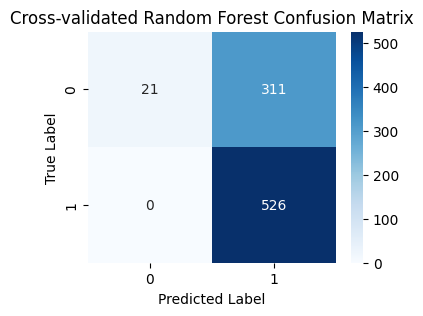


모델 성능 평가 및 시각화 완료.


In [12]:
y_pred_proba_final = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba_final >= best_threshold).astype(int) # y_pred 변수에 최종 예측 결과 저장

print("테스트 데이터 예측 완료.")

# --- 예측 결과에 대한 성능 평가 및 시각화 ---
# 성능 평가 및 시각화를 위해 사용할 모델 이름과 예측 결과를 정의합니다.
model_name = 'Cross-validated Random Forest' # 모델 이름
pred_y = y_pred # 예측 결과

print(f"\n--- {model_name} 모델 성능 ---")
print("모델 성능 평가:")

# 성능 지표 계산 (zero_division=0 추가)
accuracy = accuracy_score(y_test, pred_y)
recall = recall_score(y_test, pred_y, pos_label=minority_class, zero_division=0)
f1 = f1_score(y_test, pred_y, pos_label=minority_class, zero_division=0)
specificity = specificity_score(y_test, pred_y, pos_label=majority_class)
conf_matrix = confusion_matrix(y_test, pred_y)

# 성능 지표 출력
print(f"  정확도: {accuracy:.4f}")
print(f"  F1-Score (소수 클래스 {minority_class}): {f1:.4f}")
print(f"  재현율 (Recall, 소수 클래스 {minority_class}): {recall:.4f}")
print(f"  특이도 (Specificity, 다수 클래스 {majority_class}): {specificity:.4f}")
print("  혼동 행렬 (Confusion Matrix):")
print(conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_test, pred_y)
# 혼동 행렬 레이블을 실제 데이터의 고유 레이블로 설정
unique_labels = np.unique(np.concatenate([y_test, pred_y]))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

print("\n모델 성능 평가 및 시각화 완료.")